In [4]:
!pip install yfinance==0.2.37
!pip install matplotlib
!pip install scikit-learn
!pip install tensorflow
!pip install keras
!pip install keras scikit-learn

In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
#from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import KFold, cross_val_score

In [7]:
np.set_printoptions(threshold=np.inf)

In [8]:
import yfinance as yf

# Define the ticker symbol for S&P 500
ticker_symbol = "^GSPC"  # ticker symbol for S&P 500

# Fetch historical data
sp500_data = yf.download(ticker_symbol, start="2020-01-01", end="2024-03-20")

print(sp500_data.tail())

[*********************100%%**********************]  1 of 1 completed

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2024-03-13  5173.490234  5179.140137  5151.879883  5165.310059  5165.310059   
2024-03-14  5175.140137  5176.850098  5123.299805  5150.479980  5150.479980   
2024-03-15  5123.310059  5136.859863  5104.350098  5117.089844  5117.089844   
2024-03-18  5154.770020  5175.600098  5145.470215  5149.419922  5149.419922   
2024-03-19  5139.089844  5180.310059  5131.589844  5178.509766  5178.509766   

                Volume  
Date                    
2024-03-13  4282890000  
2024-03-14  4687970000  
2024-03-15  7753670000  
2024-03-18  4036220000  
2024-03-19  4031760000  


In [9]:
# Reset index to make Date a column in dataframe
sp500_data.reset_index(inplace=True)

SP500_df = sp500_data.copy()
display(SP500_df)
print(f"Before filling in missing dates: {SP500_df.shape}")

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,3244.669922,3258.139893,3235.530029,3257.850098,3257.850098,3459930000
1,2020-01-03,3226.360107,3246.149902,3222.340088,3234.850098,3234.850098,3484700000
2,2020-01-06,3217.550049,3246.840088,3214.639893,3246.280029,3246.280029,3702460000
3,2020-01-07,3241.860107,3244.909912,3232.429932,3237.179932,3237.179932,3435910000
4,2020-01-08,3238.590088,3267.070068,3236.669922,3253.050049,3253.050049,3726840000
...,...,...,...,...,...,...,...
1055,2024-03-13,5173.490234,5179.140137,5151.879883,5165.310059,5165.310059,4282890000
1056,2024-03-14,5175.140137,5176.850098,5123.299805,5150.479980,5150.479980,4687970000
1057,2024-03-15,5123.310059,5136.859863,5104.350098,5117.089844,5117.089844,7753670000
1058,2024-03-18,5154.770020,5175.600098,5145.470215,5149.419922,5149.419922,4036220000


Before filling in missing dates: (1060, 7)


In [10]:
# Setting 'Date' column as the index for now to fill in missing dates
SP500_df.set_index('Date', inplace=True)

# Complete date range from the earliest date to the latest date (2020-01-02 to 2024-03-19)
complete_date_range = pd.date_range(start=SP500_df.index.min(), end=SP500_df.index.max())

# Reindex with complete date range
SP500_df = SP500_df.reindex(complete_date_range)

# Forward fill missing values (filling in missing data for non-trading days with the last available trading day's values)
SP500_df.fillna(method='ffill', inplace=True)

# Reset index to convert 'Date' back to a feature column
SP500_df.reset_index(inplace=True)
SP500_df.rename(columns={'index': 'Date', 'Close': 'S&P500 Close'}, inplace=True)

display(SP500_df)
print(f"After filling in missing dates: {SP500_df.shape}")

/tmp/ipykernel_274/4268144180.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  SP500_df.fillna(method='ffill', inplace=True)


,Date,Open,High,Low,S&P500 Close,Adj Close,Volume
0,2020-01-02,3244.669922,3258.139893,3235.530029,3257.850098,3257.850098,3.459930e+09
1,2020-01-03,3226.360107,3246.149902,3222.340088,3234.850098,3234.850098,3.484700e+09
2,2020-01-04,3226.360107,3246.149902,3222.340088,3234.850098,3234.850098,3.484700e+09
3,2020-01-05,3226.360107,3246.149902,3222.340088,3234.850098,3234.850098,3.484700e+09
4,2020-01-06,3217.550049,3246.840088,3214.639893,3246.280029,3246.280029,3.702460e+09
...,...,...,...,...,...,...,...
1534,2024-03-15,5123.310059,5136.859863,5104.350098,5117.089844,5117.089844,7.753670e+09
1535,2024-03-16,5123.310059,5136.859863,5104.350098,5117.089844,5117.089844,7.753670e+09
1536,2024-03-17,5123.310059,5136.859863,5104.350098,5117.089844,5117.089844,7.753670e+09
1537,2024-03-18,5154.770020,5175.600098,5145.470215,5149.419922,5149.419922,4.036220e+09


After filling in missing dates: (1539, 7)


In [11]:
df_BTC = pd.read_csv('BTC-USD-200102-240319.csv')
df_BTC['Date'] = pd.to_datetime(df_BTC['Date'], format='%Y-%m-%d')
df_BTC.rename(columns={'Close': 'BTC Close'}, inplace=True)
#df_BTC['Date'] = df_BTC['Date'].dt.strftime('%Y-%m-%d')
display(df_BTC)

df_InterestRate = pd.read_csv('InterestRate-200102-240319.csv')
df_InterestRate['Date'] = pd.to_datetime(df_InterestRate['Date'], format='%Y-%m-%d')
#df_InterestRate['Date'] = df_InterestRate['Date'].dt.strftime('%Y-%m-%d')
display(df_InterestRate)

,Date,Open,High,Low,BTC Close,Adj Close,Volume
0,2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,20802083465
1,2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,28111481032
2,2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,18444271275
3,2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,7411.317383,19725074095
4,2020-01-06,7410.452148,7781.867188,7409.292969,7769.219238,7769.219238,23276261598
...,...,...,...,...,...,...,...
1534,2024-03-15,71387.875000,72357.132813,65630.695313,69403.773438,69403.773438,78320453976
1535,2024-03-16,69392.484375,70046.273438,64801.394531,65315.117188,65315.117188,46842198371
1536,2024-03-17,65316.343750,68845.718750,64545.316406,68390.625000,68390.625000,44716864318
1537,2024-03-18,68371.304688,68897.132813,66594.226563,67548.593750,67548.593750,49261579492


,Date,Int Rate
0,2020-01-02,1.55
1,2020-01-03,1.55
2,2020-01-04,1.55
3,2020-01-05,1.55
4,2020-01-06,1.55
...,...,...
1534,2024-03-15,5.33
1535,2024-03-16,5.33
1536,2024-03-17,5.33
1537,2024-03-18,5.33


In [12]:
# Merge df_BTC with df_SP on the 'Date' column, selecting only the 'Close' columns
merged_df = pd.merge(df_BTC[['Date', 'BTC Close']], SP500_df[['Date', 'S&P500 Close']], on='Date')

# Merge the result with df_InterestRate on the 'Date' column
merged_df = pd.merge(merged_df, df_InterestRate[['Date', 'Int Rate']], on='Date')

merged_df.head()

,Date,BTC Close,S&P500 Close,Int Rate
0,2020-01-02,6985.470215,3257.850098,1.55
1,2020-01-03,7344.884277,3234.850098,1.55
2,2020-01-04,7410.656738,3234.850098,1.55
3,2020-01-05,7411.317383,3234.850098,1.55
4,2020-01-06,7769.219238,3246.280029,1.55


In [13]:
#Create a new column for the next day's BTC-USD closing price
# Shift the 'Close' column by one row to get the next day's Close value
merged_df['BTC-USD Next Day Close'] = merged_df['BTC Close'].shift(-1)

# Replace the NaN value in the last row of 'Next Day Close' column with 67,913.67
merged_df.loc[merged_df['Date'] == '2024-03-19', 'BTC-USD Next Day Close'] = 67913.67
merged_df.tail()

,Date,BTC Close,S&P500 Close,Int Rate,BTC-USD Next Day Close
1534,2024-03-15,69403.773438,5117.089844,5.33,65315.117188
1535,2024-03-16,65315.117188,5117.089844,5.33,68390.625000
1536,2024-03-17,68390.625000,5117.089844,5.33,67548.593750
1537,2024-03-18,67548.593750,5149.419922,5.33,61912.773438
1538,2024-03-19,61912.773438,5178.509766,5.33,67913.670000


In [14]:
# Create the 'Price Change Indicator' column based on the difference between 'Next Day Close' and 'Close'
merged_df['Price Change Indicator'] = pd.cut(merged_df['BTC-USD Next Day Close'] - merged_df['BTC Close'], bins=[float('-inf'), 0, float('inf')], labels=[0, 1])
merged_df

,Date,BTC Close,S&P500 Close,Int Rate,BTC-USD Next Day Close,Price Change Indicator
0,2020-01-02,6985.470215,3257.850098,1.55,7344.884277,1
1,2020-01-03,7344.884277,3234.850098,1.55,7410.656738,1
2,2020-01-04,7410.656738,3234.850098,1.55,7411.317383,1
3,2020-01-05,7411.317383,3234.850098,1.55,7769.219238,1
4,2020-01-06,7769.219238,3246.280029,1.55,8163.692383,1
...,...,...,...,...,...,...
1534,2024-03-15,69403.773438,5117.089844,5.33,65315.117188,0
1535,2024-03-16,65315.117188,5117.089844,5.33,68390.625000,1
1536,2024-03-17,68390.625000,5117.089844,5.33,67548.593750,0
1537,2024-03-18,67548.593750,5149.419922,5.33,61912.773438,0


In [15]:
# using data from 2021-10-12 to 2023-12-19
start_date = '2021-10-12'
end_date = '2023-12-19'

new_merged_df = merged_df.copy()
new_merged_df = new_merged_df[(new_merged_df['Date'] >= start_date) & (new_merged_df['Date'] <= end_date)]
new_merged_df.reset_index(inplace=True)
new_merged_df

,index,Date,BTC Close,S&P500 Close,Int Rate,BTC-USD Next Day Close,Price Change Indicator
0,649,2021-10-12,56041.058594,4350.649902,0.08,57401.097656,1
1,650,2021-10-13,57401.097656,4363.799805,0.08,57321.523438,0
2,651,2021-10-14,57321.523438,4438.259766,0.08,61593.949219,1
3,652,2021-10-15,61593.949219,4471.370117,0.08,60892.179688,0
4,653,2021-10-16,60892.179688,4471.370117,0.08,61553.617188,1
...,...,...,...,...,...,...,...
794,1443,2023-12-15,41929.757813,4719.189941,5.33,42240.117188,1
795,1444,2023-12-16,42240.117188,4719.189941,5.33,41364.664063,0
796,1445,2023-12-17,41364.664063,4719.189941,5.33,42623.539063,1
797,1446,2023-12-18,42623.539063,4740.560059,5.33,42270.527344,0


In [16]:
# Checking for any null values
print(new_merged_df.isnull().sum())

print(new_merged_df.shape)

index                     0
Date                      0
BTC Close                 0
S&P500 Close              0
Int Rate                  0
BTC-USD Next Day Close    0
Price Change Indicator    0
dtype: int64
(799, 7)


In [17]:
train_and_validation_size = int(len(new_merged_df)*0.90)
print(train_and_validation_size)
test_size = len(new_merged_df) - train_and_validation_size
print(test_size)
#train_data,test_data = merged_df[0:train_size,:],merged_df[train_size:len(merged_df),:]

train_and_validation_data = new_merged_df[0:train_and_validation_size]
#print(train_and_validation_data)

test_data = new_merged_df[train_and_validation_size:len(new_merged_df)]
#print(test_data)

#print("Columns in train_and_validation_data:", train_and_validation_data.columns)
#print("Columns in test_data:", test_data.columns)

# Normalising features
columns_to_normalize = ['BTC Close', 'S&P500 Close', 'Int Rate']

scaler = MinMaxScaler()

scaler.fit(train_and_validation_data[columns_to_normalize])

train_and_validation_data[columns_to_normalize] = scaler.transform(train_and_validation_data[columns_to_normalize])
test_data[columns_to_normalize] = scaler.transform(test_data[columns_to_normalize])

719
80


/tmp/ipykernel_274/2921248182.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_and_validation_data[columns_to_normalize] = scaler.transform(train_and_validation_data[columns_to_normalize])
/tmp/ipykernel_274/2921248182.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[columns_to_normalize] = scaler.transform(test_data[columns_to_normalize])


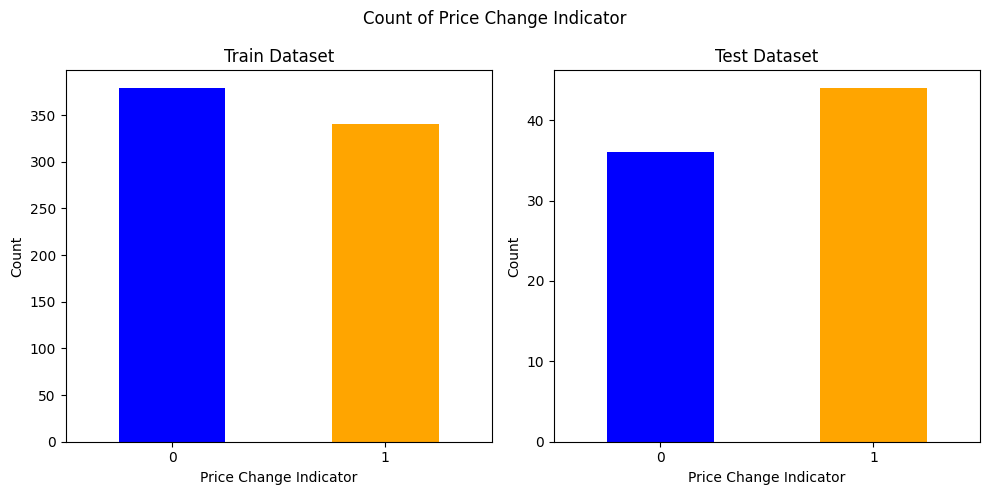

In [18]:
# Visualisation of counts of price decrease or increase datapoints in train & test dataset

# Plotting the distribution for train dataset
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
train_and_validation_data['Price Change Indicator'].value_counts().sort_index().plot(kind='bar', color=['blue', 'orange'])
plt.title('Train Dataset')
plt.xlabel('Price Change Indicator')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.ylabel('Count')

# Plotting the distribution for test dataset
plt.subplot(1, 2, 2)
test_data['Price Change Indicator'].value_counts().sort_index().plot(kind='bar', color=['blue', 'orange'])
plt.title('Test Dataset')
plt.xlabel('Price Change Indicator')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.ylabel('Count')

plt.suptitle('Count of Price Change Indicator')
plt.tight_layout()
plt.show()

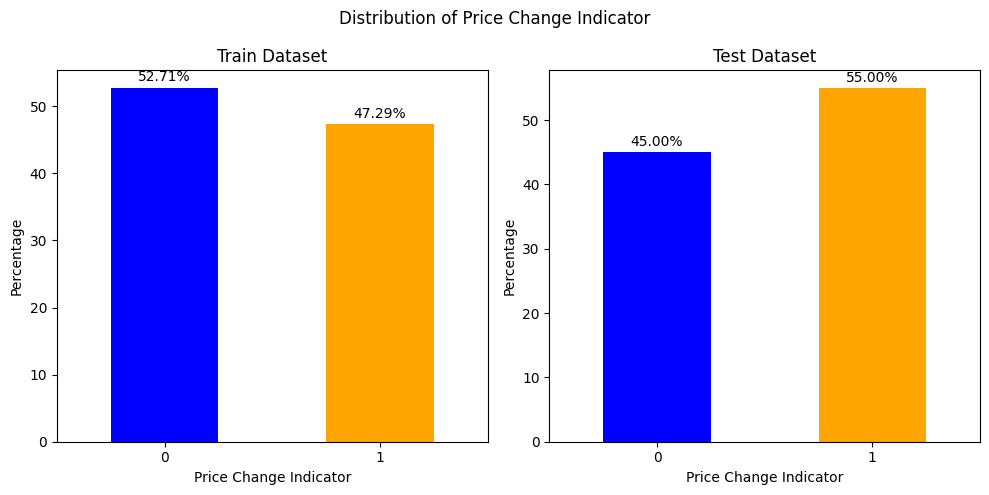

In [19]:
# Visualisation of percentage of price decrease or increase datapoints in train & test dataset

# Calculate percentage of 1s and 0s in train dataset
train_percentage = train_and_validation_data['Price Change Indicator'].value_counts(normalize=True) * 100
train_percentage = train_percentage.sort_index()

# Calculate percentage of 1s and 0s in test dataset
test_percentage = test_data['Price Change Indicator'].value_counts(normalize=True) * 100
test_percentage = test_percentage.sort_index()

# Plotting the percentage for train dataset
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
train_percentage.plot(kind='bar', color=['blue', 'orange'])
plt.title('Train Dataset')
plt.xlabel('Price Change Indicator')
plt.ylabel('Percentage')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal

# Adding percentage values on top of each bar
for i, percentage in enumerate(train_percentage):
    plt.text(i, percentage + 1, f'{percentage:.2f}%', ha='center')

# Plotting the percentage for test dataset
plt.subplot(1, 2, 2)
test_percentage.plot(kind='bar', color=['blue', 'orange'])
plt.title('Test Dataset')
plt.xlabel('Price Change Indicator')
plt.ylabel('Percentage')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal

# Adding percentage values on top of each bar
for i, percentage in enumerate(test_percentage):
    plt.text(i, percentage + 1, f'{percentage:.2f}%', ha='center')

plt.suptitle('Distribution of Price Change Indicator')
plt.tight_layout()
plt.show()

In [20]:
# To create sequences of 10-day ranges from merged_df
def creating_data_sequences(data, dateRange=10):
    x1 = []
    x2 = []
    x3 = []
    y = []
    for i in range(dateRange, data.shape[0]+1):   # for i from 10 to (len(rows of data))
        # lists containing data[0 to 9], data[1 to 10], data[2 to 11] and so on
        x1.append(data['S&P500 Close'].iloc[i-dateRange:i]) #e.g. i=0, range of index of data included is 0 to 9
        x2.append(data['Int Rate'].iloc[i-dateRange:i])
        x3.append(data['BTC Close'].iloc[i-dateRange:i])
        y.append(data['Price Change Indicator'].iloc[i-1])
    #print((np.array(x1)).shape)
    #print((np.array(x2)).shape)
    X = np.stack((np.array(x1), np.array(x2), np.array(x3)), axis=-1)
    return X, np.array(y)

### Iteration 1: tanh activation & adam optimizer

In [31]:
X_train_and_validation, y_train_and_validation = creating_data_sequences(train_and_validation_data)

# Split data into train (90%) and val (10%)
X_train, X_val, y_train, y_val = train_test_split(X_train_and_validation, y_train_and_validation, test_size=0.1, random_state=42)

print(X_train.shape) #

# For train and validation dataset
# Reshape inputs for LSTM model (to ensure)
# 3D numpy array with dimensions [samples, timesteps, features], where samples = number of data points, timesteps = length of each sequence, features = number of features for each time step
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 3))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 3))

y_train = y_train.reshape(len(y_train), 1)
y_val = y_val.reshape(len(y_val), 1)

# For test dataset
X_test, y_test = creating_data_sequences(test_data)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 3))
y_test = y_test.reshape(len(y_test), 1)

# LSTM model with dropout regularisation to prevent overfitting
model = Sequential()
model.add(Bidirectional(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=32)))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='tanh'))

# Compiling
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training and store history
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))

predicted_probabilities = model.predict(X_test)

(639, 10, 3)
Epoch 1/30


2024-04-19 12:25:07.408711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 12:25:07.411292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 12:25:07.413239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/20 [=====================>........] - ETA: 0s - loss: 0.9140 - accuracy: 0.4646

2024-04-19 12:25:15.499704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 12:25:15.502300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 12:25:15.504312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

20/20 [==============================] - 10s 90ms/step - loss: 0.8776 - accuracy: 0.4648 - val_loss: 0.6845 - val_accuracy: 0.5915
Epoch 2/30
20/20 [==============================] - 0s 10ms/step - loss: 0.7385 - accuracy: 0.4726 - val_loss: 0.6621 - val_accuracy: 0.6056
Epoch 3/30
20/20 [==============================] - 0s 10ms/step - loss: 0.7200 - accuracy: 0.4820 - val_loss: 0.6634 - val_accuracy: 0.6479
Epoch 4/30
20/20 [==============================] - 0s 10ms/step - loss: 0.7116 - accuracy: 0.5055 - val_loss: 0.6651 - val_accuracy: 0.5634
Epoch 5/30
20/20 [==============================] - 0s 10ms/step - loss: 0.7103 - accuracy: 0.5164 - val_loss: 0.6677 - val_accuracy: 0.5775
Epoch 6/30
20/20 [==============================] - 0s 10ms/step - loss: 0.7130 - accuracy: 0.4695 - val_loss: 0.6709 - val_accuracy: 0.6197
Epoch 7/30
20/20 [==============================] - 0s 10ms/step - loss: 0.7100 - accuracy: 0.4789 - val_loss: 0.6730 - val_accuracy: 0.5493
Epoch 8/30
20/20 [=====

2024-04-19 12:25:23.072111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 12:25:23.074635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 12:25:23.076590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 2s 4ms/step


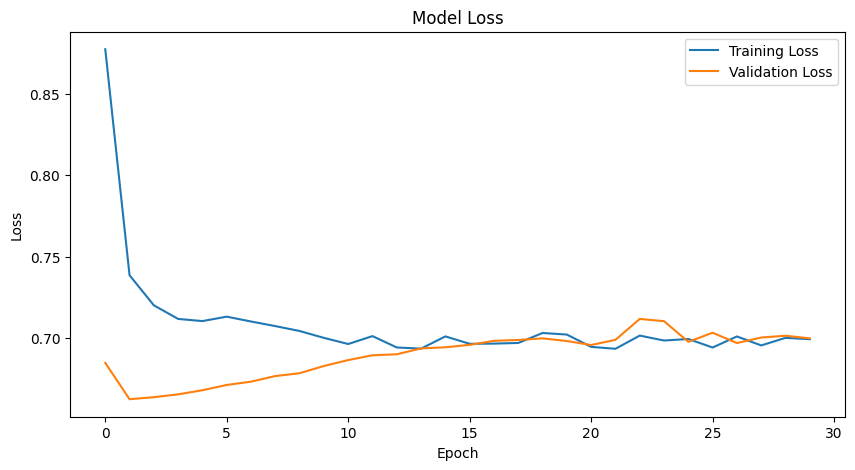

In [32]:
# Visualising losses over epochs
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [33]:
from sklearn.metrics import roc_curve
# Use the encoded true labels and predicted probabilities to find the best threshold
# (Assuming ROC curve analysis is used)
fpr, tpr, thresholds = roc_curve(y_test, predicted_probabilities)
youden_index = tpr - fpr
best_threshold_index = np.argmax(youden_index)
best_threshold = thresholds[best_threshold_index]
print(best_threshold)

# Apply threshold to predicted probabilities to obtain binary predictions
binary_predictions = [1 if prob >= best_threshold else 0 for prob in predicted_probabilities]
predicted_labels = binary_predictions

0.43665892


In [34]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels, pos_label=1)
recall = recall_score(y_test, predicted_labels, pos_label=1)
f1 = f1_score(y_test, predicted_labels, pos_label=1)
#roc_auc = roc_auc_score(y_test, predicted_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
#print("ROC-AUC score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

from sklearn.metrics import classification_report

report = classification_report(y_test, predicted_labels)

print("Classification Report:\n", report)


Accuracy: 0.6056338028169014
Precision: 0.6101694915254238
Recall: 0.8780487804878049
F1-score: 0.72
Confusion Matrix:
[[ 7 23]
 [ 5 36]]
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.23      0.33        30
           1       0.61      0.88      0.72        41

    accuracy                           0.61        71
   macro avg       0.60      0.56      0.53        71
weighted avg       0.60      0.61      0.56        71



### Backtesting of Iteration 1

In [35]:
# using data from 2020-06-04 to 2020-07-04
start_date = '2020-06-04'
end_date = '2020-07-04'

backtesting_df = merged_df[(merged_df['Date'] >= start_date) & (merged_df['Date'] <= end_date)]
backtesting_df.reset_index(inplace=True)
backtesting_df

,index,Date,BTC Close,S&P500 Close,Int Rate,BTC-USD Next Day Close,Price Change Indicator
0,154,2020-06-04,9800.636719,3112.350098,0.06,9665.533203,0
1,155,2020-06-05,9665.533203,3193.929932,0.07,9653.679688,0
2,156,2020-06-06,9653.679688,3193.929932,0.07,9758.852539,1
3,157,2020-06-07,9758.852539,3193.929932,0.07,9771.489258,1
4,158,2020-06-08,9771.489258,3232.389893,0.07,9795.700195,1
5,159,2020-06-09,9795.700195,3207.179932,0.07,9870.094727,1
6,160,2020-06-10,9870.094727,3190.139893,0.08,9321.781250,0
7,161,2020-06-11,9321.781250,3002.100098,0.08,9480.843750,1
8,162,2020-06-12,9480.843750,3041.310059,0.08,9475.277344,0
9,163,2020-06-13,9475.277344,3041.310059,0.08,9386.788086,0


In [36]:
# backtesting_df.loc[:, 'S&P500 Close'] = scaler.transform(backtesting_df[['S&P500 Close']])
# backtesting_df.loc[:, 'Int Rate'] = scaler.transform(backtesting_df[['Int Rate']])
# backtesting_df.loc[:, 'BTC Close'] = scaler.transform(backtesting_df[['BTC Close']])

backtesting_df[columns_to_normalize] = scaler.transform(backtesting_df[columns_to_normalize])

X_backtest, y_backtest = creating_data_sequences(backtesting_df)
X_backtest = np.reshape(X_backtest, (X_backtest.shape[0], X_backtest.shape[1], 3))
y_backtest = y_backtest.reshape(len(y_backtest), 1)

predicted_probabilities = model.predict(X_backtest)

1/1 [==============================] - 0s 27ms/step


/tmp/ipykernel_274/3602257733.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtesting_df[columns_to_normalize] = scaler.transform(backtesting_df[columns_to_normalize])


In [37]:
binary_predictions = [1 if prob >= best_threshold else 0 for prob in predicted_probabilities]
predicted_labels = binary_predictions

In [38]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_backtest, predicted_labels)
precision = precision_score(y_backtest, predicted_labels, pos_label=1)
recall = recall_score(y_backtest, predicted_labels, pos_label=1)
f1 = f1_score(y_backtest, predicted_labels, pos_label=1)
#roc_auc = roc_auc_score(y_test, predicted_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
#print("ROC-AUC score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_backtest, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

from sklearn.metrics import classification_report

report = classification_report(y_backtest, predicted_labels)

print("Classification Report:\n", report)


Accuracy: 0.36363636363636365
Precision: 0.36363636363636365
Recall: 1.0
F1-score: 0.5333333333333333
Confusion Matrix:
[[ 0 14]
 [ 0  8]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.36      1.00      0.53         8

    accuracy                           0.36        22
   macro avg       0.18      0.50      0.27        22
weighted avg       0.13      0.36      0.19        22



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Iteration 2: Using Grid Search and Stratified K-Fold

In [41]:
from sklearn.model_selection import StratifiedKFold
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import make_scorer, roc_auc_score, f1_score

def create_lstm_model(optimizer='adam', activation='tanh'):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=64, return_sequences=True, input_shape=(X_train_and_validation.shape[1], X_train_and_validation.shape[2]))))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(units=32)))
    model.add(Dropout(0.2))
    model.add(Dense(units=1, activation='tanh'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

lstm_clf = KerasClassifier(build_fn=create_lstm_model, verbose=1)

# Define the hyperparameters grid
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'activation': ['relu', 'sigmoid', 'tanh', 'leaky_relu']
}

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
f1_scorer = make_scorer(f1_score)
roc_auc_scorer = make_scorer(roc_auc_score)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=lstm_clf, param_grid=param_grid, cv=skf, scoring={'f1': f1_scorer, 'roc_auc': roc_auc_scorer}, refit='f1', verbose=1)

# Perform the grid search
grid_result = grid_search.fit(X_train_and_validation, y_train_and_validation)

# Print the best score and best parameters
print("Best F1 Score:", grid_result.best_score_)
print("Best Parameters:", grid_result.best_params_)

/tmp/ipykernel_274/1237884849.py:15: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_clf = KerasClassifier(build_fn=create_lstm_model, verbose=1)


Fitting 3 folds for each of 8 candidates, totalling 24 fits


2024-04-19 13:43:49.651905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:43:49.653963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:43:49.655413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - 9s 9ms/step - loss: 1.0059 - accuracy: 0.4630


2024-04-19 13:43:58.275615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:43:58.277363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:43:58.278681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 1s 4ms/step


2024-04-19 13:43:59.674970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:43:59.676719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:43:59.678081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - 8s 8ms/step - loss: 1.3863 - accuracy: 0.5264


2024-04-19 13:44:07.409446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:44:07.411654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:44:07.413131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 1s 4ms/step


2024-04-19 13:44:08.819324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:44:08.821715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:44:08.823152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - 9s 8ms/step - loss: 1.0356 - accuracy: 0.5127


2024-04-19 13:44:17.623662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:44:17.625535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:44:17.626837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 1s 4ms/step


2024-04-19 13:44:18.973140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:44:18.975009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:44:18.976336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - 8s 8ms/step - loss: 1.0846 - accuracy: 0.4884


2024-04-19 13:44:26.504342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:44:26.506078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:44:26.507367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 1s 3ms/step


2024-04-19 13:44:27.768432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:44:27.770064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:44:27.771409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - 7s 8ms/step - loss: 7.2396 - accuracy: 0.5307


2024-04-19 13:44:35.308882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:44:35.310923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:44:35.312351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 1s 3ms/step


2024-04-19 13:44:36.594031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:44:36.595935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:44:36.597306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - 9s 8ms/step - loss: 1.2265 - accuracy: 0.4895


2024-04-19 13:44:45.638384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:44:45.640174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:44:45.641584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 1s 3ms/step


2024-04-19 13:44:46.978964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:44:46.980751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:44:46.982030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - 7s 8ms/step - loss: 1.1049 - accuracy: 0.5201


2024-04-19 13:44:54.443423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:44:54.445088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:44:54.446416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 1s 3ms/step


2024-04-19 13:44:55.737503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:44:55.739488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:44:55.740847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - 9s 8ms/step - loss: 1.2215 - accuracy: 0.5307


2024-04-19 13:45:05.201863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:45:05.203718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:45:05.205052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 1s 4ms/step


2024-04-19 13:45:06.621845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:45:06.623711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:45:06.625126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - 8s 7ms/step - loss: 1.2969 - accuracy: 0.5169


2024-04-19 13:45:14.233504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:45:14.235383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:45:14.236749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 1s 3ms/step


2024-04-19 13:45:15.552930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:45:15.554752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:45:15.556082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - 8s 8ms/step - loss: 0.8113 - accuracy: 0.4630


2024-04-19 13:45:23.188135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:45:23.190072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:45:23.191416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 1s 3ms/step


2024-04-19 13:45:24.489774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:45:24.491602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:45:24.492979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - 9s 8ms/step - loss: 1.0075 - accuracy: 0.5011


2024-04-19 13:45:33.738551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:45:33.740390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:45:33.741712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 1s 3ms/step


2024-04-19 13:45:35.066563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:45:35.068483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:45:35.069825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - 8s 8ms/step - loss: 1.3144 - accuracy: 0.5338


2024-04-19 13:45:42.639361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:45:42.641065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:45:42.642513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 1s 4ms/step


2024-04-19 13:45:43.946402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:45:43.948131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:45:43.949472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - 10s 9ms/step - loss: 2.8366 - accuracy: 0.5180


2024-04-19 13:45:53.530510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:45:53.532472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:45:53.533833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 1s 4ms/step


2024-04-19 13:45:54.927972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:45:54.929720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:45:54.931051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - 8s 9ms/step - loss: 0.8146 - accuracy: 0.5011


2024-04-19 13:46:02.485684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:46:02.487497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:46:02.523581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 1s 3ms/step


2024-04-19 13:46:03.830964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:46:03.832773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:46:03.834084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - 8s 9ms/step - loss: 1.5675 - accuracy: 0.5190


2024-04-19 13:46:11.411714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:46:11.413662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:46:11.415079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 1s 3ms/step


2024-04-19 13:46:12.714594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:46:12.716456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:46:12.717758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - 9s 8ms/step - loss: 0.8242 - accuracy: 0.4968


2024-04-19 13:46:22.129646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:46:22.133819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:46:22.135173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 1s 3ms/step


2024-04-19 13:46:23.449673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:46:23.451618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:46:23.453010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - 8s 8ms/step - loss: 1.5505 - accuracy: 0.5137


2024-04-19 13:46:30.998142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:46:30.999949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:46:31.001256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 1s 3ms/step


2024-04-19 13:46:32.294198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:46:32.295966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:46:32.297269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - 10s 9ms/step - loss: 0.8365 - accuracy: 0.5506


2024-04-19 13:46:42.123968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:46:42.125833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:46:42.127156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 1s 4ms/step


2024-04-19 13:46:43.521283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:46:43.523163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:46:43.524517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - 8s 9ms/step - loss: 1.3050 - accuracy: 0.4820


2024-04-19 13:46:51.296919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:46:51.298853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:46:51.300140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 1s 4ms/step


2024-04-19 13:46:52.624148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:46:52.625954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:46:52.627281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - 8s 7ms/step - loss: 1.3675 - accuracy: 0.5074


2024-04-19 13:47:00.378356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:47:00.380149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:47:00.381504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 1s 3ms/step


2024-04-19 13:47:01.733861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:47:01.735795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:47:01.737146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - 9s 8ms/step - loss: 7.2569 - accuracy: 0.5295


2024-04-19 13:47:11.089332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:47:11.091189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:47:11.092518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 1s 4ms/step


2024-04-19 13:47:12.433107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:47:12.435120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:47:12.436496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - 8s 8ms/step - loss: 1.2850 - accuracy: 0.4947


2024-04-19 13:47:20.009332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:47:20.011219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:47:20.012597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 1s 4ms/step


2024-04-19 13:47:21.396366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:47:21.398386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:47:21.399734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - 10s 8ms/step - loss: 0.8663 - accuracy: 0.5074


2024-04-19 13:47:31.042195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:47:31.044104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:47:31.045453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 1s 4ms/step


2024-04-19 13:47:32.498570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:47:32.500499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:47:32.501835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - 8s 8ms/step - loss: 0.9499 - accuracy: 0.5105


2024-04-19 13:47:40.161816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:47:40.163522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:47:40.164808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 1s 3ms/step


2024-04-19 13:47:41.518852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:47:41.520705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:47:41.522157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

23/23 [==============================] - 8s 8ms/step - loss: 0.8489 - accuracy: 0.4845
Best F1 Score: 0.6008579188031519
Best Parameters: {'activation': 'sigmoid', 'optimizer': 'adam'}


In [45]:
# Use the best parameters found from grid search
best_optimizer = grid_result.best_params_['optimizer']
best_activation = grid_result.best_params_['activation']

# Create the LSTM model with the best hyperparameters
best_lstm_model = create_lstm_model(optimizer=best_optimizer, activation=best_activation)

X_train, X_val, y_train, y_val = train_test_split(X_train_and_validation, y_train_and_validation, test_size=0.1, random_state=42)

# Train the model on the entire training dataset
history = best_lstm_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))

predicted_probabilities = best_lstm_model.predict(X_test)

from sklearn.metrics import roc_curve
# Use the encoded true labels and predicted probabilities to find the best threshold
# (Assuming ROC curve analysis is used)
fpr, tpr, thresholds = roc_curve(y_test, predicted_probabilities)
youden_index = tpr - fpr
best_threshold_index = np.argmax(youden_index)
best_threshold = thresholds[best_threshold_index]
print(best_threshold)

# Apply threshold to predicted probabilities to obtain binary predictions
binary_predictions = [1 if prob >= best_threshold else 0 for prob in predicted_probabilities]
predicted_labels = binary_predictions

Epoch 1/30


2024-04-19 13:59:15.638585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:59:15.641524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:59:15.643762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

19/20 [===========================>..] - ETA: 0s - loss: 2.1686 - accuracy: 0.4868

2024-04-19 13:59:24.127582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:59:24.130253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:59:24.132232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

20/20 [==============================] - 10s 90ms/step - loss: 2.1061 - accuracy: 0.4820 - val_loss: 0.7460 - val_accuracy: 0.5070
Epoch 2/30
20/20 [==============================] - 0s 10ms/step - loss: 0.7515 - accuracy: 0.4945 - val_loss: 0.6609 - val_accuracy: 0.5915
Epoch 3/30
20/20 [==============================] - 0s 11ms/step - loss: 0.7205 - accuracy: 0.5086 - val_loss: 0.6620 - val_accuracy: 0.6197
Epoch 4/30
20/20 [==============================] - 0s 10ms/step - loss: 0.7148 - accuracy: 0.4945 - val_loss: 0.6638 - val_accuracy: 0.5915
Epoch 5/30
20/20 [==============================] - 0s 11ms/step - loss: 0.7119 - accuracy: 0.4883 - val_loss: 0.6657 - val_accuracy: 0.5634
Epoch 6/30
20/20 [==============================] - 0s 11ms/step - loss: 0.7130 - accuracy: 0.4789 - val_loss: 0.6681 - val_accuracy: 0.5775
Epoch 7/30
20/20 [==============================] - 0s 11ms/step - loss: 0.7132 - accuracy: 0.4757 - val_loss: 0.6703 - val_accuracy: 0.5775
Epoch 8/30
20/20 [=====

2024-04-19 13:59:31.846106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-19 13:59:31.848926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-19 13:59:31.850987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 2s 4ms/step
0.521993


In [46]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels, pos_label=1)
recall = recall_score(y_test, predicted_labels, pos_label=1)
f1 = f1_score(y_test, predicted_labels, pos_label=1)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

conf_matrix = confusion_matrix(y_test, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

from sklearn.metrics import classification_report

report = classification_report(y_test, predicted_labels)

print("Classification Report:\n", report)

Accuracy: 0.5352112676056338
Precision: 0.6333333333333333
Recall: 0.4634146341463415
F1-score: 0.5352112676056338
Confusion Matrix:
[[19 11]
 [22 19]]
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.63      0.54        30
           1       0.63      0.46      0.54        41

    accuracy                           0.54        71
   macro avg       0.55      0.55      0.54        71
weighted avg       0.56      0.54      0.54        71



### Backtesting of Iteration 2

In [ ]:
# using data from 2020-06-04 to 2020-07-04
start_date = '2020-06-04'
end_date = '2020-07-04'

backtesting_df = merged_df[(merged_df['Date'] >= start_date) & (merged_df['Date'] <= end_date)]
backtesting_df.reset_index(inplace=True)

In [48]:
backtesting_df[columns_to_normalize] = scaler.transform(backtesting_df[columns_to_normalize])

X_backtest, y_backtest = creating_data_sequences(backtesting_df)
X_backtest = np.reshape(X_backtest, (X_backtest.shape[0], X_backtest.shape[1], 3))
y_backtest = y_backtest.reshape(len(y_backtest), 1)

predicted_probabilities = best_lstm_model.predict(X_backtest)

1/1 [==============================] - 0s 35ms/step


/tmp/ipykernel_274/2099272660.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtesting_df[columns_to_normalize] = scaler.transform(backtesting_df[columns_to_normalize])


In [49]:
binary_predictions = [1 if prob >= best_threshold else 0 for prob in predicted_probabilities]
predicted_labels = binary_predictions

In [50]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_backtest, predicted_labels)
precision = precision_score(y_backtest, predicted_labels, pos_label=1)
recall = recall_score(y_backtest, predicted_labels, pos_label=1)
f1 = f1_score(y_backtest, predicted_labels, pos_label=1)
#roc_auc = roc_auc_score(y_test, predicted_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
#print("ROC-AUC score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_backtest, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

from sklearn.metrics import classification_report
report = classification_report(y_backtest, predicted_labels)
print("Classification Report:\n", report)

Accuracy: 0.6363636363636364
Precision: 0.0
Recall: 0.0
F1-score: 0.0
Confusion Matrix:
[[14  0]
 [ 8  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.64      1.00      0.78        14
           1       0.00      0.00      0.00         8

    accuracy                           0.64        22
   macro avg       0.32      0.50      0.39        22
weighted avg       0.40      0.64      0.49        22



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_